Оформляем единый github-репозиторий, в котором представлены результаты всех 3 лабораторных работ. Github-репозиторий должен иметь модульную структуру, jupyter-notebook, в котором даны комментарии к каждой ячейке с кодом и readme.


**Лабораторная работа №6 (Проведение исследований с моделями классификации)**
1.	Выбор начальных условий

a.	Выбрать набор данных для задачи классификации (у каждого студента должен быть уникальный набор данных) и обосновать его выбор (реальная практическая задача)  
b.	Выбрать метрики качества и обосновать их выбор  

2.	Создание бейзлайна и оценка качества

a.	Обучить модели (как сверточные так и «трансформерные») из torchvision для выбранного набора данных  
b.	Оценить качество моделей по выбранным метрикам на выбранном наборе данных  

3.	Улучшение бейзлайна

a.	Сформулировать гипотезы (аугментации данных, подбор моделей, подбор гиперпараметров и т.д.)  
b.	Проверить гипотезы  
c.	Сформировать улучшенный бейзлайн по результатам проверки гипотез  
d.	Обучить модели с улучшенным бейзлайном на выбранном наборе данных  
e.	Оценить качество моделей с улучшенным бейзлайном по выбранным метрикам на выбранном наборе данных  
f.	Сравнить результаты моделей с улучшенным бейзлайном в сравнении с результатами из пункта 2   
g.	Сделать выводы  

4.	Имплементация алгоритма машинного обучения

a.	Самостоятельно имплементировать модели машинного обучения   
b.	Обучить имплементированные модели на выбранном наборе данных  
c.	Оценить качество имплементированных моделей по выбранным метрикам на выбранном наборе данных  
d.	Сравнить результаты имплементированных моделей в сравнении с результатами из пункта 2  
e.	Сделать выводы  
f.	Добавить техники из улучшенного бейзлайна (пункт 3с)  
g.	Обучить модели для выбранных наборов данных  
h.	Оценить качество моделей по выбранным метрикам на выбранном наборе данных  
i.	Сравнить результаты моделей в сравнении с результатами из пункта 3  
j.	Сделать выводы  


**Лабораторная работа №7 (Проведение исследований моделями семантической сегментации)** – повторить пункты 2-4 из лабораторной работы №6, но использовать segmentation_models.pytorch вместо torchvision


**Лабораторная работа №8 (Проведение исследований моделями обнаружения и распознавания объектов)** – повторить пункты 2-4 из лабораторной работы №6, но использовать ultralytics (семейство моделей YOLOv11) вместо torchvision

# **Лабораторная работа №6 (Проведение исследований с моделями классификации)**

## 1. Выбор начальных условий

### a. Набор данных

Был выбран датасет [Animals-10](https://www.kaggle.com/datasets/alessiocorrado99/animals10) , содержащий изображения 10 различных классов животных (например, кошки, собаки, лошади и другие). Этот датасет имеет широкий спектр практических применений, таких как автоматизированные системы видеонаблюдения для мониторинга диких животных, инструменты для анализа экосистем или приложения для помощи в изучении биоразнообразия. Подобная система может быть использована, например, в заповедниках или национальных парках для отслеживания популяций животных и предотвращения конфликтов между человеком и дикой природой.

In [ ]:
!pip install opendatasets

In [ ]:
# 2. Загрузка датасета (потребуется авторизация в Kaggle)
import opendatasets as od
dataset_url = "https://www.kaggle.com/datasets/alessiocorrado99/animals10"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: fedor7
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10


In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Монтируем Google Drive [[1]]

Mounted at /content/drive


### b. Метрики качества


В качестве метрики качества будем использовать accuracy - как показатель верно угаданных классов.

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

Пробуем использовать cuda для torch. Инициализируем transform:

- ресайз до 224 на 224 (на чем была обучена бейзлайн модель);
- в формат tensor;
- с нормализацией.

Инициализируем даталоадеры для train выборки и validation выборки.

In [ ]:
# Флаг для управления режимом (True - загрузить модель, False - обучить с нуля)
LOAD_MODEL = True

# 2. Импорт библиотек
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 3. Подготовка данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 4. Загрузка датасета
dataset = ImageFolder(root="animals10/raw-img", transform=transform)

# Стратифицированное разделение на train/val (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

# DataLoader'ы
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# 5. Инициализация моделей (10 классов)
num_classes = 10

# ResNet-18
model_cnn = models.resnet18(pretrained=True)
model_cnn.fc = torch.nn.Linear(model_cnn.fc.in_features, num_classes)

# Vision Transformer (ViT)
model_vit = models.vit_b_16(pretrained=True)
model_vit.heads = torch.nn.Linear(model_vit.heads.head.in_features, num_classes)

# 6. Загрузка предобученной модели или обучение с нуля
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weig

В качестве сверточной модели будем использовать resnet18, а в качестве трансформерной модели будем использовать ViT. Скачаем их и сделаем свою функцию для обучения.

In [ ]:
def load_or_train_model(model, model_path, lr=0.001, epochs=5):
    try:
        # Попытка загрузить модель, если она существует
        if LOAD_MODEL and torch.load(model_path):
            model.load_state_dict(torch.load(model_path))
            print(f"Модель успешно загружена из {model_path}")
            return model
    except FileNotFoundError:
        print(f"Модель не найдена по пути {model_path}. Начинается обучение...")

    # Обучение модели
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

    # Сохранение модели после обучения
    torch.save(model.state_dict(), model_path)
    print(f"Модель сохранена по пути: {model_path}")
    return model

# 7. Оценка качества
def evaluate_model(model):
    model.eval()
    y_true = []
    y_pred = []
    y_proba = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_proba.extend(probs.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    try:
        roc_auc = roc_auc_score(y_true, y_proba, multi_class='ovr')
    except:
        roc_auc = -1  # Если не хватает классов
    return accuracy, f1, roc_auc

In [ ]:
# Путь для сохранения/загрузки модели
MODEL_PATH_CNN = "/content/drive/MyDrive/models/resnet18_animals.pth"
MODEL_PATH_VIT = "/content/drive/MyDrive/models/vit_animals.pth"

# 8. Запуск обучения или загрузка модели
print("ResNet-18:")
model_cnn = load_or_train_model(model_cnn, MODEL_PATH_CNN, lr=0.001, epochs=5)
acc_cnn, f1_cnn, roc_cnn = evaluate_model(model_cnn)
print(f"ResNet-18: Accuracy={acc_cnn:.3f}, F1={f1_cnn:.3f}, ROC-AUC={roc_cnn:.3f}")

print("Vision Transformer:")
model_vit = load_or_train_model(model_vit, MODEL_PATH_VIT, lr=0.0001, epochs=5)
acc_vit, f1_vit, roc_vit = evaluate_model(model_vit)
print(f"ViT: Accuracy={acc_vit:.3f}, F1={f1_vit:.3f}, ROC-AUC={roc_vit:.3f}")

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

ResNet-18:
Модель не найдена по пути /content/drive/MyDrive/resnet18_animals.pth. Начинается обучение...


Epoch 1/5: 100%|██████████| 655/655 [02:07<00:00,  5.13it/s, loss=0.566]


Epoch 1/5, Loss: 0.6247


Epoch 2/5: 100%|██████████| 655/655 [02:06<00:00,  5.18it/s, loss=0.597]


Epoch 2/5, Loss: 0.4039


Epoch 3/5: 100%|██████████| 655/655 [02:06<00:00,  5.19it/s, loss=0.51]


Epoch 3/5, Loss: 0.3152


Epoch 4/5: 100%|██████████| 655/655 [02:07<00:00,  5.15it/s, loss=0.0182]


Epoch 4/5, Loss: 0.2622


Epoch 5/5: 100%|██████████| 655/655 [02:15<00:00,  4.84it/s, loss=0.275]


Epoch 5/5, Loss: 0.2299
Модель сохранена по пути: /content/drive/MyDrive/resnet18_animals.pth


100%|██████████| 164/164 [00:23<00:00,  6.84it/s]


ResNet-18: Accuracy=0.882, F1=0.874, ROC-AUC=0.992
Vision Transformer:
Модель не найдена по пути /content/drive/MyDrive/vit_animals.pth. Начинается обучение...


Epoch 1/5: 100%|██████████| 655/655 [13:05<00:00,  1.20s/it, loss=0.0343]


Epoch 1/5, Loss: 0.2115


Epoch 2/5: 100%|██████████| 655/655 [13:04<00:00,  1.20s/it, loss=0.0645]


Epoch 2/5, Loss: 0.1257


Epoch 3/5: 100%|██████████| 655/655 [13:02<00:00,  1.19s/it, loss=0.00565]


Epoch 3/5, Loss: 0.0941


Epoch 4/5: 100%|██████████| 655/655 [13:03<00:00,  1.20s/it, loss=0.0112]


Epoch 4/5, Loss: 0.0849


Epoch 5/5: 100%|██████████| 655/655 [13:02<00:00,  1.19s/it, loss=0.00416]


Epoch 5/5, Loss: 0.0638
Модель сохранена по пути: /content/drive/MyDrive/vit_animals.pth


100%|██████████| 164/164 [01:11<00:00,  2.28it/s]

ViT: Accuracy=0.946, F1=0.940, ROC-AUC=0.997


Получаем прекрасный итоговый accuracy и loss после 5 эпох:

ResNet-18: Accuracy=0.882, Loss=0.2299

ViT: Accuracy=0.946, Loss=0.0638

Визуализация предсказываний

In [ ]:
# Импортируем словарь перевода из файла translate.py
import ast

# Загрузка словаря перевода из файла translate.py
translate_path = "animals10/translate.py"
with open(translate_path, "r") as file:
    translate_content = file.read()
    # Извлекаем словарь из содержимого файла
    translate = ast.literal_eval(translate_content.split("translate = ")[1])

# Функция для безопасного перевода с учетом обратного поиска
def safe_translate(class_name):
    """
    Безопасная функция перевода:
    - Если ключ найден, возвращает translate[class_name].
    - Если ключа нет, ищет обратное соответствие: translate[name] = class_name.
    - Если ничего не найдено, возвращает исходное значение.
    """
    if class_name in translate:
        return translate[class_name]
    # Обратный поиск: ищем ключ, где значение равно class_name
    reverse_lookup = {v: k for k, v in translate.items()}
    if class_name in reverse_lookup:
        return reverse_lookup[class_name]
    # Если ничего не найдено, возвращаем исходное значение
    return class_name

import random
import matplotlib.pyplot as plt

# Функция для отображения результатов с переводом
def visualize_predictions(model, dataset, subset, num_images=5):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Выбираем случайные индексы из подвыборки (например, val_data)
    indices = random.sample(range(len(subset)), num_images)
    images, true_labels = [], []

    for idx in indices:
        img, label = subset[idx]
        images.append(img)
        true_labels.append(label)

    # Преобразуем список изображений в тензор
    images_tensor = torch.stack(images).to(device)  # 4D тензор

    # Получаем предсказания модели
    with torch.no_grad():
        outputs = model(images_tensor)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1).cpu().numpy()

    # Визуализация
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0).cpu().numpy()  # Переводим в формат (H, W, C)
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Денормализация [[1]]
        img = img.clip(0, 1)  # Ограничение значений пикселей в диапазоне [0, 1]

        # Используем безопасную функцию перевода для меток
        true_class = safe_translate(dataset.classes[true_labels[i]])
        pred_class = safe_translate(dataset.classes[preds[i]])

        ax.imshow(img)
        ax.set_title(f"True: {true_class}\nPred: {pred_class}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

ResNet-18 Predictions:


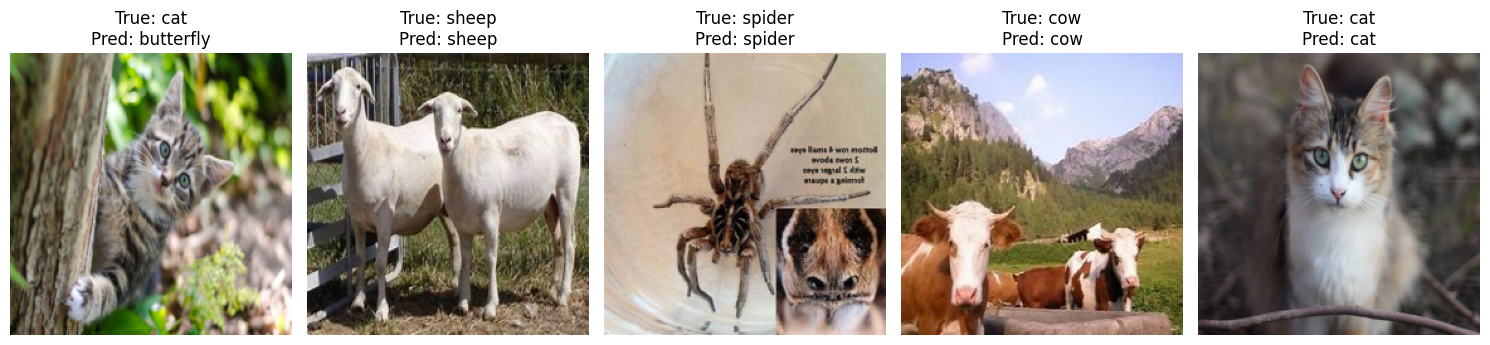

Vision Transformer Predictions:


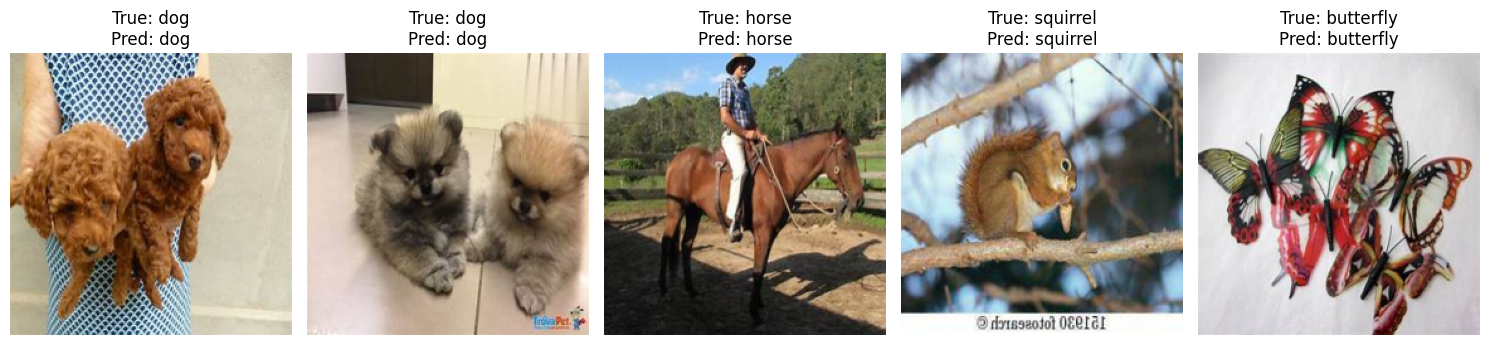

In [ ]:
# Пример использования
print("ResNet-18 Predictions:")
visualize_predictions(model_cnn, dataset, val_data)

print("Vision Transformer Predictions:")
visualize_predictions(model_vit, dataset, val_data)

## 3. Улучшение бейзлайна

В качестве улучшения бейзлайна я решил произвести аугментацию (RandomRotation(30) - Добавляем случайные повороты; ColorJitter(brightness=0.2, contrast=0.2) - Изменение яркости/контраста), добавление shedulerа, а также уменьшение learning rate в 10 раз.

In [ ]:
# 1. Подключение к Google Drive
# from google.colab import drive
# drive.mount('/content/drive')  # Монтируем Google Drive [[1]]

# Флаг для управления режимом (True - загрузить модель, False - обучить с нуля)
LOAD_MODEL = False

# 2. Импорт библиотек
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 3. Подготовка данных
transform_optimize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30), # Добавляем случайные повороты
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Изменение яркости/контраста
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 4. Загрузка датасета
dataset = ImageFolder(root="animals10/raw-img", transform=transform_optimize)

# Стратифицированное разделение на train/val (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

# DataLoader'ы
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

num_classes = 10

# ResNet-18
model_cnn_optimize = models.resnet18(pretrained=True)
model_cnn_optimize.fc = torch.nn.Linear(model_cnn.fc.in_features, num_classes)

# Vision Transformer (ViT)
model_vit_optimize = models.vit_b_16(pretrained=True)
model_vit_optimize.heads = torch.nn.Linear(model_vit_optimize.heads.head.in_features, num_classes)

# 6. Загрузка предобученной модели или обучение с нуля
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weig

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def load_or_train_model_2(model, model_path, lr=0.001, epochs=5):
    try:
        # Попытка загрузить модель, если она существует
        if LOAD_MODEL and torch.load(model_path):
            model.load_state_dict(torch.load(model_path))
            print(f"Модель успешно загружена из {model_path}")
            return model
    except FileNotFoundError:
        print(f"Модель не найдена по пути {model_path}. Начинается обучение...")

    # Обучение модели
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)  # Добавляем scheduler
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')
        scheduler.step(running_loss / len(train_loader))  # Обновляем lr

    # Сохранение модели после обучения
    torch.save(model.state_dict(), model_path)
    print(f"Модель сохранена по пути: {model_path}")
    return model

In [ ]:
# Путь для сохранения/загрузки модели
MODEL_OPTIMIZE_PATH_CNN = "/content/drive/MyDrive/models/resnet18_optimize_animals.pth"
MODEL_OPTIMIZE_PATH_VIT = "/content/drive/MyDrive/models/vit_optimize_animals.pth"

# 8. Запуск обучения или загрузка модели
print("ResNet-18 на улучшенном бейзлайне:")
model_cnn_optimize = load_or_train_model_2(model_cnn_optimize, MODEL_OPTIMIZE_PATH_CNN, lr=0.0001, epochs=5)
acc_cnn, f1_cnn, roc_cnn = evaluate_model(model_cnn_optimize)
print(f"ResNet-18: Accuracy={acc_cnn:.3f}, F1={f1_cnn:.3f}, ROC-AUC={roc_cnn:.3f}")

print("Vision Transformer на улучшенном бейзлайне:")
model_vit_optimize = load_or_train_model_2(model_vit_optimize, MODEL_OPTIMIZE_PATH_VIT, lr=0.00001, epochs=5)
acc_vit, f1_vit, roc_vit = evaluate_model(model_vit_optimize)
print(f"ViT: Accuracy={acc_vit:.3f}, F1={f1_vit:.3f}, ROC-AUC={roc_vit:.3f}")

ResNet-18 на улучшенном бейзлайне:


Epoch 1/5: 100%|██████████| 655/655 [02:42<00:00,  4.03it/s, loss=0.484]


Epoch 1/5, Loss: 0.3324


Epoch 2/5: 100%|██████████| 655/655 [02:38<00:00,  4.12it/s, loss=0.0587]


Epoch 2/5, Loss: 0.1640


Epoch 3/5: 100%|██████████| 655/655 [02:38<00:00,  4.13it/s, loss=0.146]


Epoch 3/5, Loss: 0.1262


Epoch 4/5: 100%|██████████| 655/655 [02:39<00:00,  4.10it/s, loss=0.621]


Epoch 4/5, Loss: 0.1085


Epoch 5/5: 100%|██████████| 655/655 [02:38<00:00,  4.12it/s, loss=0.287]


Epoch 5/5, Loss: 0.0936
Модель сохранена по пути: /content/drive/MyDrive/models/resnet18_optimize_animals.pth


100%|██████████| 164/164 [00:31<00:00,  5.23it/s]


ResNet-18: Accuracy=0.952, F1=0.948, ROC-AUC=0.998
Vision Transformer на улучшенном бейзлайне:


Epoch 1/5: 100%|██████████| 655/655 [13:35<00:00,  1.25s/it, loss=0.0145]


Epoch 1/5, Loss: 0.2730


Epoch 2/5: 100%|██████████| 655/655 [13:36<00:00,  1.25s/it, loss=0.01]


Epoch 2/5, Loss: 0.0616


Epoch 3/5: 100%|██████████| 655/655 [13:35<00:00,  1.24s/it, loss=0.0119]


Epoch 3/5, Loss: 0.0416


Epoch 4/5: 100%|██████████| 655/655 [13:36<00:00,  1.25s/it, loss=0.00433]


Epoch 4/5, Loss: 0.0295


Epoch 5/5: 100%|██████████| 655/655 [13:37<00:00,  1.25s/it, loss=0.0261]


Epoch 5/5, Loss: 0.0236
Модель сохранена по пути: /content/drive/MyDrive/models/vit_optimize_animals.pth


100%|██████████| 164/164 [01:18<00:00,  2.08it/s]

ViT: Accuracy=0.985, F1=0.983, ROC-AUC=0.999


Как мы видим, гипотезы оправдали себя и показали улучшение accuracy:

ResNet-18: Accuracy=0.952, Loss=0.0936

ViT: Accuracy=0.985, Loss=0.0236

ResNet-18 Predictions:


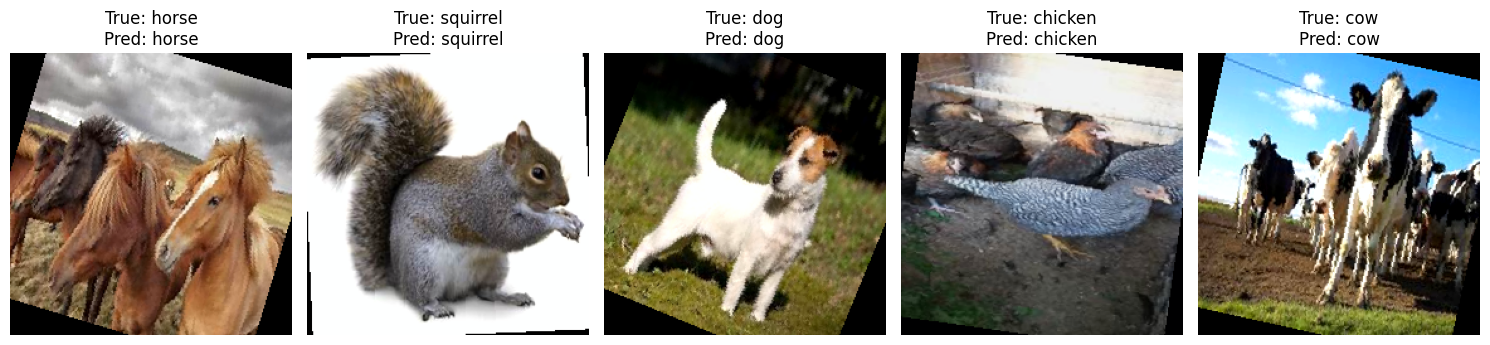

Vision Transformer Predictions:


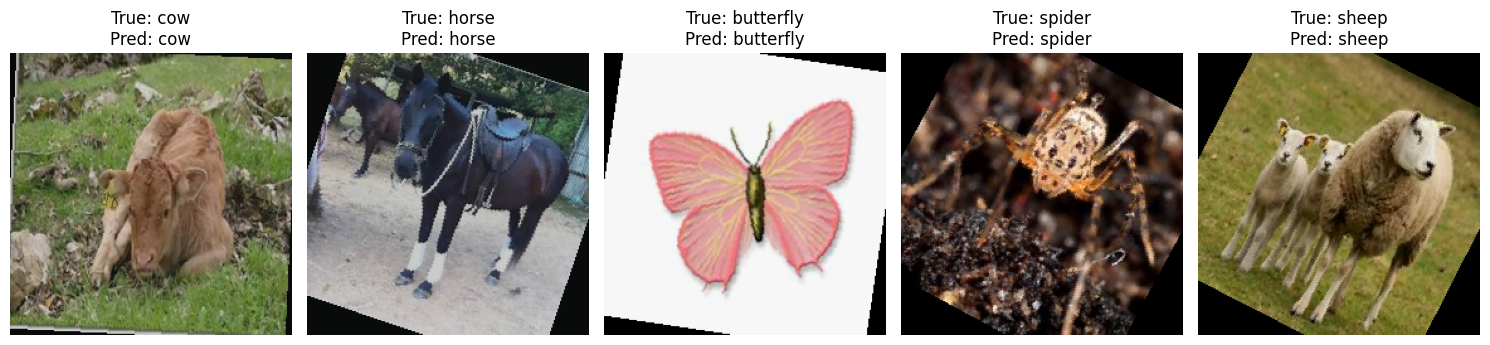

In [ ]:
print("ResNet-18 Predictions:")
visualize_predictions(model_cnn_optimize, dataset, val_data)

print("Vision Transformer Predictions:")
visualize_predictions(model_vit_optimize, dataset, val_data)

## 4. Имплементация алгоритма машинного обучения

На данном шаге самостоятельно имплементируем сверточную и трансформер модели машинного обучения.

In [ ]:
import torch
import torch.nn as nn

class MyCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MyCNN, self).__init__()

        # Сверточные слои
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Вход: (3, 224, 224)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Выход: (32, 112, 112)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Вход: (32, 112, 112)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Выход: (64, 56, 56)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Вход: (64, 56, 56)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Выход: (128, 28, 28)

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Вход: (128, 28, 28)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Выход: (256, 14, 14)
        )

        # Полносвязные слои
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),  # Размер входа: 256 * 14 * 14
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # Выход: num_classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
MODEL_PATH_CNN_MY = "/content/drive/MyDrive/models/myCNN_animals.pth"

# 3. Подготовка данных
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 4. Загрузка датасета
dataset = ImageFolder(root="animals10/raw-img", transform=transform)

# Стратифицированное разделение на train/val (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

# DataLoader'ы
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# 5. Инициализация моделей (10 классов)
num_classes = 10

# Инициализация модели
model_cnn_my = MyCNN(num_classes=num_classes)

# Обучение модели
model_cnn_my = load_or_train_model(model_cnn_my, MODEL_PATH_CNN_MY, lr=0.001, epochs=5)

# Оценка модели
acc_cnn, f1_cnn, roc_cnn = evaluate_model(model_cnn_my)
print(f"MyCNN: Accuracy={acc_cnn:.3f}, F1={f1_cnn:.3f}, ROC-AUC={roc_cnn:.3f}")

Epoch 1/5: 100%|██████████| 655/655 [02:14<00:00,  4.87it/s, loss=1.42]


Epoch 1/5, Loss: 1.4404


Epoch 2/5: 100%|██████████| 655/655 [02:00<00:00,  5.42it/s, loss=1.22]


Epoch 2/5, Loss: 1.0743


Epoch 3/5: 100%|██████████| 655/655 [01:59<00:00,  5.49it/s, loss=0.891]


Epoch 3/5, Loss: 0.8939


Epoch 4/5: 100%|██████████| 655/655 [01:58<00:00,  5.52it/s, loss=1.38]


Epoch 4/5, Loss: 0.7693


Epoch 5/5: 100%|██████████| 655/655 [01:58<00:00,  5.53it/s, loss=0.731]


Epoch 5/5, Loss: 0.6673
Модель сохранена по пути: /content/drive/MyDrive/models/myCNN_animals.pth


100%|██████████| 164/164 [00:22<00:00,  7.42it/s]


MyCNN: Accuracy=0.743, F1=0.719, ROC-AUC=0.964


После обучения собственной имплементации cnn можем увидеть что Loss выше и Accuracy ниже чем у импортированной модели:

MyCNN: Accuracy=0.743, Loss=0.6673

Визуализация

MyCNN Predictions:


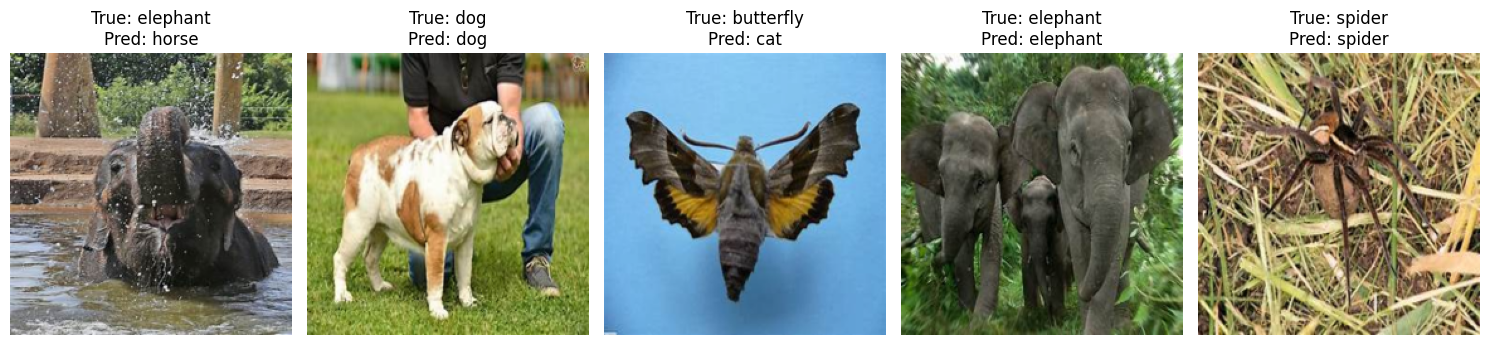

In [ ]:
print("MyCNN Predictions:")
visualize_predictions(model_cnn_my, dataset, val_data)

In [ ]:
MODEL_PATH_CNN_MY_OPTIMIZED = "/content/drive/MyDrive/models/myCNN_optimized_animals.pth"

# 3. Подготовка данных
transform_optimize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30), # Добавляем случайные повороты
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Изменение яркости/контраста
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 4. Загрузка датасета
dataset = ImageFolder(root="animals10/raw-img", transform=transform_optimize)

# Стратифицированное разделение на train/val (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

# DataLoader'ы
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

num_classes = 10


# Инициализация модели
model_cnn_my_optimized = MyCNN(num_classes=num_classes)

# Обучение модели
model_cnn_my_optimized = load_or_train_model_2(model_cnn_my_optimized, MODEL_PATH_CNN_MY_OPTIMIZED, lr=0.0001, epochs=5)

# Оценка модели
acc_cnn, f1_cnn, roc_cnn = evaluate_model(model_cnn_my_optimized)
print(f"MyCNN: Accuracy={acc_cnn:.3f}, F1={f1_cnn:.3f}, ROC-AUC={roc_cnn:.3f}")

Epoch 1/5: 100%|██████████| 655/655 [02:34<00:00,  4.23it/s, loss=0.989]


Epoch 1/5, Loss: 1.5206


Epoch 2/5: 100%|██████████| 655/655 [02:33<00:00,  4.25it/s, loss=1.59]


Epoch 2/5, Loss: 1.2058


Epoch 3/5: 100%|██████████| 655/655 [02:33<00:00,  4.28it/s, loss=0.7]


Epoch 3/5, Loss: 1.0617


Epoch 4/5: 100%|██████████| 655/655 [02:34<00:00,  4.25it/s, loss=1.19]


Epoch 4/5, Loss: 0.9854


Epoch 5/5: 100%|██████████| 655/655 [02:33<00:00,  4.25it/s, loss=1.3]


Epoch 5/5, Loss: 0.9241
Модель сохранена по пути: /content/drive/MyDrive/models/myCNN_optimized_animals.pth


100%|██████████| 164/164 [00:30<00:00,  5.37it/s]


MyCNN: Accuracy=0.656, F1=0.630, ROC-AUC=0.942


После обучения собственной имплементации cnn на улучшенном бейзлайне можем увидеть что модель стала хуже работать:

MyCNN: Accuracy=0.656, Loss=0.9241

MyCNN Predictions:


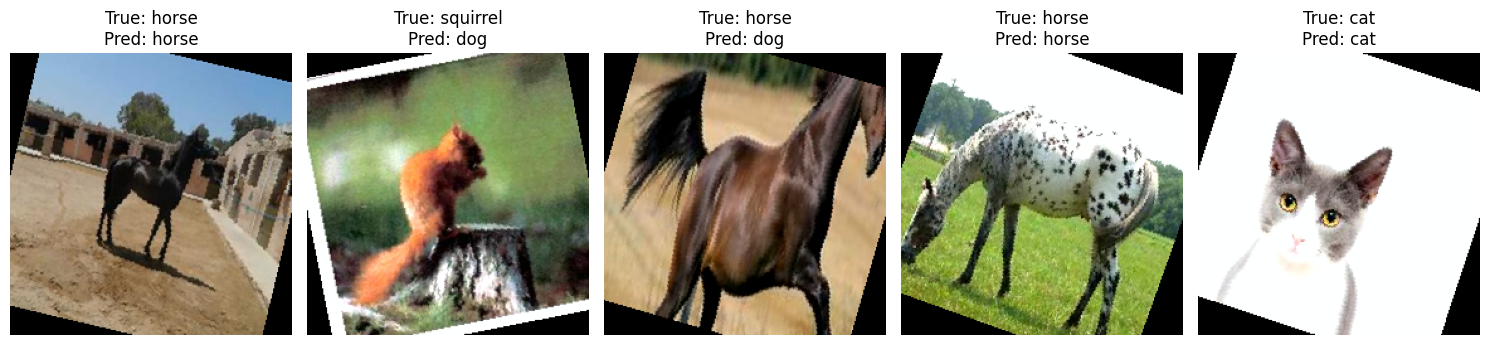

In [ ]:
print("MyCNN Predictions:")
visualize_predictions(model_cnn_my_optimized, dataset, val_data)

Vision Transformer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 1. Реализация собственной ViT
class MyViT(nn.Module):
    def __init__(self,
                 image_size=224,
                 patch_size=16,
                 num_classes=10,
                 dim=768,
                 depth=12,
                 heads=12,
                 mlp_dim=3072,
                 dropout=0.1):
        super().__init__()

        assert image_size % patch_size == 0, "Image dimensions must be divisible by patch size"
        num_patches = (image_size // patch_size) ** 2
        patch_dim = 3 * patch_size ** 2

        self.patch_size = patch_size

        # Патч-эмбеддинг
        self.patch_embedding = nn.Sequential(
            nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2)
        )

        # Позиционные эмбеддинги
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(dropout)

        # Трансформерные блоки
        self.transformer = nn.Transformer(
            d_model=dim,
            nhead=heads,
            num_encoder_layers=depth,
            dim_feedforward=mlp_dim,
            dropout=dropout,
            activation='gelu'
        )

        # Классификационный слой
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        # Создаем патчи
        x = self.patch_embedding(x).permute(0, 2, 1)  # (batch, num_patches, dim)

        # Добавляем CLS-токен
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Добавляем позиционные эмбеддинги
        x += self.pos_embedding
        x = self.dropout(x)

        # Трансформер
        x = self.transformer(x, x)  # (batch, num_patches+1, dim)

        # Классификация по CLS-токену
        x = x[:, 0]
        return self.mlp_head(x)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root="animals10/raw-img", transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# 5. Инициализация моделей (10 классов)
num_classes = 10

# 5. Инициализация и обучение
LOAD_MODEL = True
MODEL_PATH_VIT_MY = "/content/drive/MyDrive/models/myVit_animals.pth"

model_vit_my = MyViT(
    image_size=224,
    patch_size=16,
    num_classes=num_classes,
    dim=768,
    depth=12,
    heads=12,
    mlp_dim=3072
).to(device)

print("Обучение собственной ViT:")
model_vit_my = load_or_train_model(model_vit_my, MODEL_PATH_VIT_MY, lr=0.0001, epochs=5)

# 6. Оценка
acc, f1, roc = evaluate_model(model_vit_my)
print(f"MyViT: Accuracy={acc:.3f}, F1={f1:.3f}, ROC-AUC={roc:.3f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Обучение собственной ViT:
Модель не найдена по пути /content/drive/MyDrive/models/myVit_animals.pth. Начинается обучение...


Epoch 1/5: 100%|██████████| 655/655 [19:11<00:00,  1.76s/it, loss=2.18]


Epoch 1/5, Loss: 2.2621


Epoch 2/5: 100%|██████████| 655/655 [19:10<00:00,  1.76s/it, loss=2.12]


Epoch 2/5, Loss: 2.2377


Epoch 3/5: 100%|██████████| 655/655 [19:09<00:00,  1.75s/it, loss=2.33]


Epoch 3/5, Loss: 2.2304


Epoch 4/5: 100%|██████████| 655/655 [18:57<00:00,  1.74s/it, loss=2.15]


Epoch 4/5, Loss: 2.2255


Epoch 5/5: 100%|██████████| 655/655 [18:56<00:00,  1.73s/it, loss=2.15]


Epoch 5/5, Loss: 2.2228
Модель сохранена по пути: /content/drive/MyDrive/models/myVit_animals.pth


100%|██████████| 164/164 [01:48<00:00,  1.51it/s]

MyViT: Accuracy=0.184, F1=0.031, ROC-AUC=0.500


После обучения собственной имплементации vision transformer можем увидеть что Loss выше и Accuracy ниже чем у импортированной модели:

MyViT: Accuracy=0.184, Loss=2.2228

MyViT Predictions:


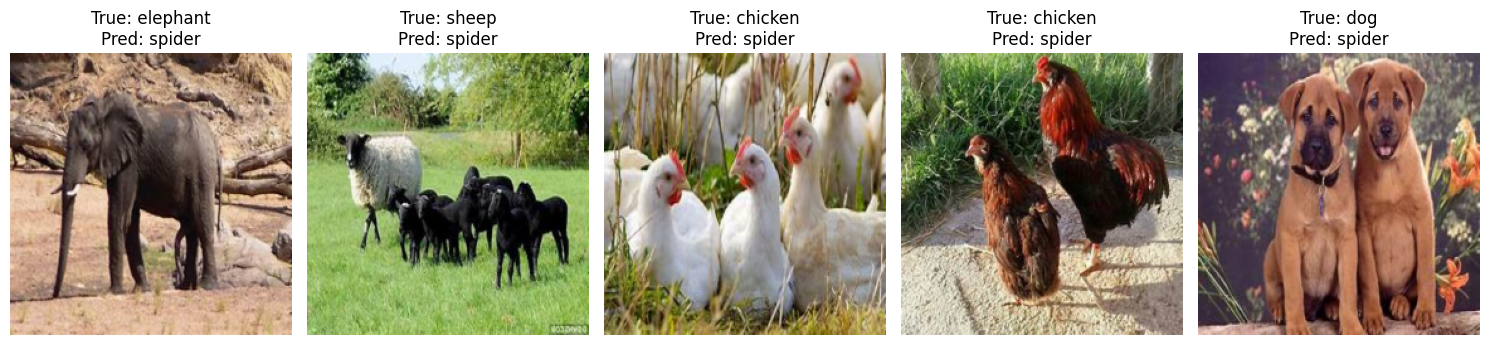

In [ ]:
print("MyViT Predictions:")
visualize_predictions(model_vit_my, dataset, val_data)

In [ ]:
# 3. Подготовка данных
transform_optimize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30), # Добавляем случайные повороты
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Изменение яркости/контраста
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 4. Загрузка датасета
dataset = ImageFolder(root="animals10/raw-img", transform=transform_optimize)

# Стратифицированное разделение на train/val (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

# DataLoader'ы
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

num_classes = 10

# 5. Инициализация и обучение
LOAD_MODEL = True
MODEL_PATH_VIT_MY_OPTIMIZED = "/content/drive/MyDrive/models/myVit_optimized_animals.pth"

model_vit_my_optimized = MyViT(
    image_size=224,
    patch_size=16,
    num_classes=num_classes,
    dim=768,
    depth=12,
    heads=12,
    mlp_dim=3072
).to(device)

print("Обучение собственной ViT на улучшенном бейзлайне:")
model_vit_my_optimized = load_or_train_model_2(model_vit_my_optimized, MODEL_PATH_VIT_MY_OPTIMIZED, lr=0.00001, epochs=5)

# 6. Оценка
acc, f1, roc = evaluate_model(model_vit_my_optimized)
print(f"MyViT: Accuracy={acc:.3f}, F1={f1:.3f}, ROC-AUC={roc:.3f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Обучение собственной ViT на улучшенном бейзлайне:
Модель не найдена по пути /content/drive/MyDrive/models/myVit_optimized_animals.pth. Начинается обучение...


Epoch 1/5: 100%|██████████| 655/655 [19:21<00:00,  1.77s/it, loss=2.32]


Epoch 1/5, Loss: 2.2603


Epoch 2/5: 100%|██████████| 655/655 [19:21<00:00,  1.77s/it, loss=2.19]


Epoch 2/5, Loss: 2.2349


Epoch 3/5: 100%|██████████| 655/655 [19:21<00:00,  1.77s/it, loss=2.12]


Epoch 3/5, Loss: 2.2324


Epoch 4/5: 100%|██████████| 655/655 [19:20<00:00,  1.77s/it, loss=2.31]


Epoch 4/5, Loss: 2.2296


Epoch 5/5: 100%|██████████| 655/655 [19:21<00:00,  1.77s/it, loss=2.11]


Epoch 5/5, Loss: 2.2242
Модель сохранена по пути: /content/drive/MyDrive/models/myVit_optimized_animals.pth


100%|██████████| 164/164 [01:56<00:00,  1.41it/s]

MyViT: Accuracy=0.185, F1=0.031, ROC-AUC=0.500


После обучения собственной имплементации vision transformer на улучшенном бейзлайне можем увидеть что Lна неё это никак не повлияло:

MyViT: Accuracy=0.185, Loss: 2.2242

MyViT Predictions:


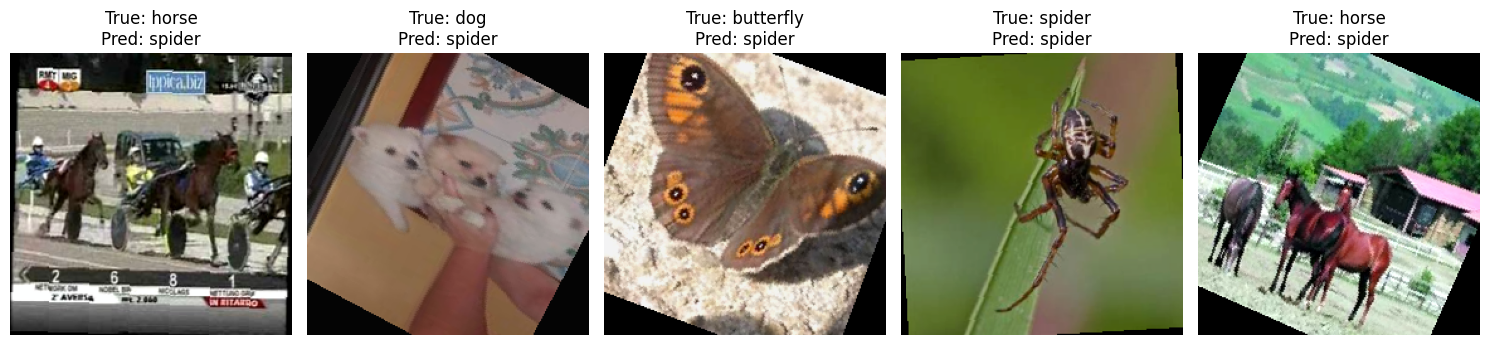

In [ ]:
print("MyViT Predictions:")
visualize_predictions(model_vit_my_optimized, dataset, val_data)